# PIK3RI trans effect histograms for all proteins


This notebook analyzes the trans effect of TP53 mutation for all proteins.

### Library Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import gseapy as gp
from gseapy.plot import barplot, dotplot

import warnings
warnings.filterwarnings("ignore")

import cptac
import cptac.utils as al

In [2]:
brain = cptac.Gbm()

### Specify Gene

In [6]:
gene = "PIK3R1"

# Transcriptomics: All Proteins

In [7]:
transcrpt = "transcriptomics"

try:
    print("\nGene: ", gene)

    #Use all proteins

    #Create dataframe in order to do comparisons with wrap_ttest
    transcrpt_df = brain.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=transcrpt)
    transcrpt_df = brain.reduce_multiindex(transcrpt_df, flatten=True)
    transcrpt_df = transcrpt_df[transcrpt_df.Sample_Status == 'Tumor'] # drop Normal samples
    #Remove Cis interactions 
    transcrpt_df = transcrpt_df.loc[:,~transcrpt_df.columns.str.contains(gene+'_transcriptomics')] # change for each gene 
    transcrpt_df = transcrpt_df.dropna(axis=1, how='all') # drop columns with all NaN data
    
    #Create the binary valued column needed to do the comparison
    for ind, row in transcrpt_df.iterrows():
        if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
            transcrpt_df.at[ind,'Label'] = 'Mutated'
        else:
            transcrpt_df.at[ind,'Label'] = 'Wildtype'

    #Format the datafram correctly
    transcrpt_df = transcrpt_df.drop(gene+"_Mutation",axis=1)
    transcrpt_df = transcrpt_df.drop(gene+"_Location",axis=1)
    transcrpt_df = transcrpt_df.drop(gene+"_Mutation_Status", axis=1)
    transcrpt_df = transcrpt_df.drop("Sample_Status",axis=1)

    #Make list of columns to be compared using t-tests
    t_col_list = list(transcrpt_df.columns)
    t_col_list.remove('Label')

    print("Doing t-test comparisons\n")
    
    #Call wrap_ttest, pass in formatted dataframe
    transcrpt_all_comparisons = al.wrap_ttest(transcrpt_df, 'Label', t_col_list, return_all=True)

    t_num_comparisons = len(t_col_list)
    print("Number of comparisons:", t_num_comparisons)
    t_bonferroni_cutoff = .05 / t_num_comparisons
    print("Bonferroni cutoff = ", t_bonferroni_cutoff)
    print("Logged Bonferroni cutoff = ", np.log10(t_bonferroni_cutoff))

except Exception as e:
    print("Error in Comparison")
    print(e)


Gene:  PIK3R1


Doing t-test comparisons

28 significant comparisons!
Number of comparisons: 60482
Bonferroni cutoff =  8.266922390132602e-07
Logged Bonferroni cutoff =  -6.0826561395096865


Transcriptomics: Print Significant Comparisons

In [8]:
transcrpt_all_comparisons = transcrpt_all_comparisons.dropna(axis=0)
transcrpt_sig_comparisons = transcrpt_all_comparisons.loc[transcrpt_all_comparisons['P_Value'] <= t_bonferroni_cutoff]
print("Number of significant comparisons for Transcriptomics: ", len(transcrpt_sig_comparisons))
transcrpt_sig_comparisons

Number of significant comparisons for Transcriptomics:  28


,Comparison,P_Value
0,AC005618.9_transcriptomics_ENSG00000279855.1,5.795172e-11
1,FP671120.4_transcriptomics_ENSG00000275530.1,2.961140e-10
2,HMGN1P10_transcriptomics_ENSG00000244101.1,5.330315e-10
3,RP11-192H6.2_transcriptomics_ENSG00000251654.2,1.123288e-09
4,RNA5SP336_transcriptomics_ENSG00000201059.1,1.370492e-09
5,MIR4722_transcriptomics_ENSG00000265672.1,1.613323e-09
6,RP11-93K22.6_transcriptomics_ENSG00000250643.1,4.866211e-09
7,CTD-2566J3.1_transcriptomics_ENSG00000258837.1,2.619960e-08
8,LEMD1-AS1_transcriptomics_ENSG00000226235.1,2.672431e-08
9,IGLV1-62_transcriptomics_ENSG00000253823.1,2.999121e-08


Transcriptomics: Histogram for all proteins

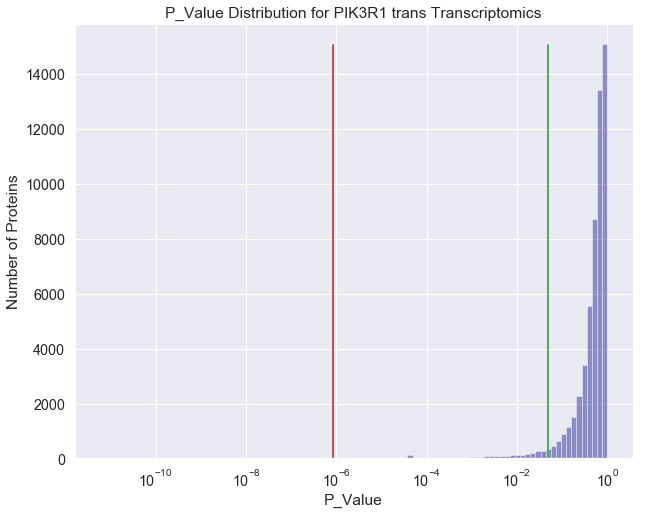

In [9]:
# Create series of p-values for Histogram
transcrpt_pval_series = transcrpt_all_comparisons['P_Value']

# Format figure size and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

# Create log scale for the x-axis
plt.xscale('log')
t_log_min, t_log_max = np.log10(transcrpt_pval_series.min()), np.log10(transcrpt_pval_series.max())
t_bins = np.logspace(t_log_min - 1, t_log_max, 100) # change bin number here
histogram = sns.distplot(transcrpt_pval_series, bins = t_bins, kde=False, color='navy') 

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Transcriptomics")
histogram.set(ylabel = 'Number of Proteins')
#plt.xlim([10e-9,10e-1])
#plt.ylim([0, 3500]) # change y-axis range

# Graph cutoffs: alpha = green, bonferroni = red
plt.axvline(t_bonferroni_cutoff, 0, 0.95, linewidth=2, color='r')
plt.axvline(0.05, 0, 0.95, linewidth=2, color='g')

plt.show()
plt.clf()
plt.close()

Transcriptomics zoomed in

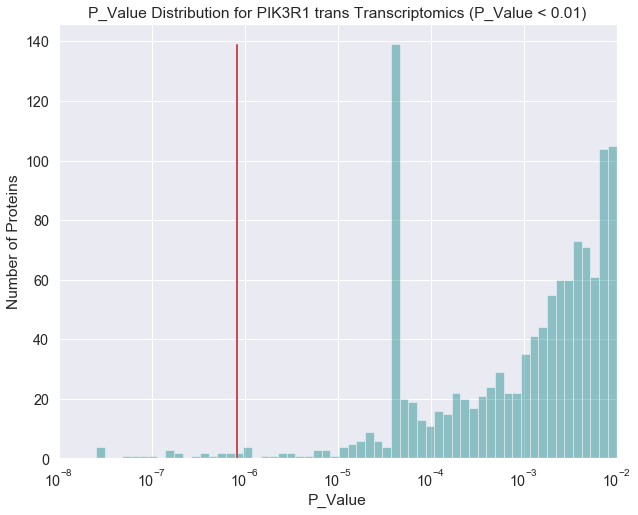

In [10]:
# Select p-values within range 0 - end_value 
t_end_value = 0.01
transcrpt_zoomed = transcrpt_pval_series.loc[transcrpt_pval_series <= t_end_value]

# Format size of figure and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

# Create log scale for the x-axis
plt.xscale('log')
t_zoomed_log_min, t_zoomed_log_max = np.log10(transcrpt_zoomed.min()),np.log10(transcrpt_zoomed.max())
t_zoomed_bins = np.logspace(t_zoomed_log_min - 1, t_zoomed_log_max, 100) # change this number for more or less bins
histogram = sns.distplot(transcrpt_zoomed, bins=t_zoomed_bins, kde=False, color='teal')

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Transcriptomics (P_Value < " + str(t_end_value) + ")")
histogram.set(ylabel = 'Number of Proteins')
plt.xlim([10e-9,10e-3])
#plt.ylim([0.0,400]) # change y axis intervals

# Create bonferroni cutoff line 
plt.axvline(t_bonferroni_cutoff, 0, .95, linewidth=2, color='r') # cutoff line parameters: (cutoff, 0, height)

plt.show()
plt.clf()
plt.close()

In [11]:
# 100 genes
t_gsea = transcrpt_all_comparisons.sort_values(by = 'P_Value')
t_first_fifty = t_gsea.iloc[:100]

# create gene list
t_genes = t_first_fifty['Comparison']
t_genes.replace(to_replace = '_transcriptomics.*$', value = '', 
                        inplace = True, regex = True) # shorten column names
t_genes.replace(to_replace = '-.*$', value = '', 
                        inplace = True, regex = True) # shorten column names
t_genes_list = list(t_genes)
print("Number of Transcriptomics comparisons for gsea: ", len(t_genes_list))

t_enr = gp.enrichr(gene_list = t_genes_list, description='Transcriptomics_Comparisons', gene_sets='KEGG_2016', 
                       outdir='Enrichment Analysis')

t_enr.res2d.head()

Number of Transcriptomics comparisons for gsea:  100


2019-11-02 16:12:26,021 Warning: No enrich terms using library KEGG_2016 when cutoff = 0.05


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
0,Axon guidance_Homo sapiens_hsa04360,1/127,0.343690,1.0,0,0,2.386065,2.548353,ABLIM3,KEGG_2016
1,Hippo signaling pathway_Homo sapiens_hsa04390,1/153,0.398103,1.0,0,0,1.980590,1.824212,AFP,KEGG_2016


# Proteomics: All Proteins

In [12]:
prot = "proteomics"

try:
    print("\nGene: ", gene)

    #Use all proteins

    #Create dataframe in order to do comparisons with wrap_ttest
    protdf = brain.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=prot)
    protdf = brain.reduce_multiindex(protdf, flatten=True)
    protdf = protdf[protdf.Sample_Status == 'Tumor'] # drop Normal samples
    
    #Remove Cis interactions 
    protdf = protdf.drop(columns = gene+"_proteomics") # change for each gene 
    protdf = protdf.dropna(axis=1, how='all') # drop columns with all NaN data
    
    #Create the binary valued column needed to do the comparison
    for ind, row in protdf.iterrows():
        if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
            protdf.at[ind,'Label'] = 'Mutated'
        else:
            protdf.at[ind,'Label'] = 'Wildtype'

    #Format the datafram correctly
    protdf = protdf.drop(gene+"_Mutation",axis=1)
    protdf = protdf.drop(gene+"_Location",axis=1)
    protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
    protdf = protdf.drop("Sample_Status",axis=1)

    #Make list of columns to be compared using t-tests
    prot_col_list = list(protdf.columns)
    prot_col_list.remove('Label')

    print("Doing t-test comparisons\n")
    
    #Call wrap_ttest, pass in formatted dataframe
    prot_all_comparisons = al.wrap_ttest(protdf, 'Label', prot_col_list, return_all=True)

    prot_num_comparisons = len(prot_col_list)
    print("Number of comparisons:", prot_num_comparisons)
    prot_bonferroni_cutoff = .05 / prot_num_comparisons
    print("Bonferroni cutoff = ", prot_bonferroni_cutoff)
    print("Logged Bonferroni cutoff = ", np.log10(prot_bonferroni_cutoff))


except Exception as e:
    print("Error in Comparison")
    print(e)


Gene:  PIK3R1


Doing t-test comparisons

No significant comparisons.
Number of comparisons: 11140
Bonferroni cutoff =  4.4883303411131066e-06
Logged Bonferroni cutoff =  -5.347915186501691


Print Significant Comparisons

In [13]:
prot_all_comparisons = prot_all_comparisons.dropna(axis=0)
prot_sig_comparisons = prot_all_comparisons.loc[prot_all_comparisons['P_Value'] <= prot_bonferroni_cutoff]
print("Number of significant Proteomics comparisons: ", len(prot_sig_comparisons))
prot_sig_comparisons

Number of significant Proteomics comparisons:  0


,Comparison,P_Value


Proteomics Histograms 

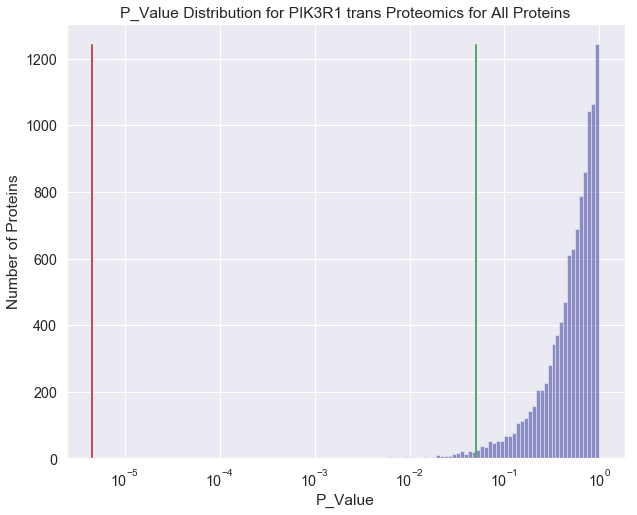

In [14]:
# Create series of p-values for Histogram
prot_pval_series = prot_all_comparisons['P_Value']

# Format figure size and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

# Create log scale for the x-axis
plt.xscale('log')
prot_log_min, prot_log_max = np.log10(prot_pval_series.min()), np.log10(prot_pval_series.max())
prot_bins = np.logspace(prot_log_min - 1, prot_log_max, 100) # change bin number here
histogram = sns.distplot(prot_pval_series, bins = prot_bins, kde=False, color='navy') # bins 100 

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Proteomics for All Proteins")
histogram.set(ylabel = 'Number of Proteins')
#plt.xlim([10e-8,10e-1]) # change x-axis range
#plt.ylim([0, 3500]) # change y-axis range

# Graph cutoffs: alpha = green, bonferroni = red
plt.axvline(prot_bonferroni_cutoff, 0, 0.95, linewidth=2, color='r')
plt.axvline(0.05, 0, 0.95, linewidth=2, color='g')

plt.show()
plt.clf()
plt.close()

Proteomics zoomed in 

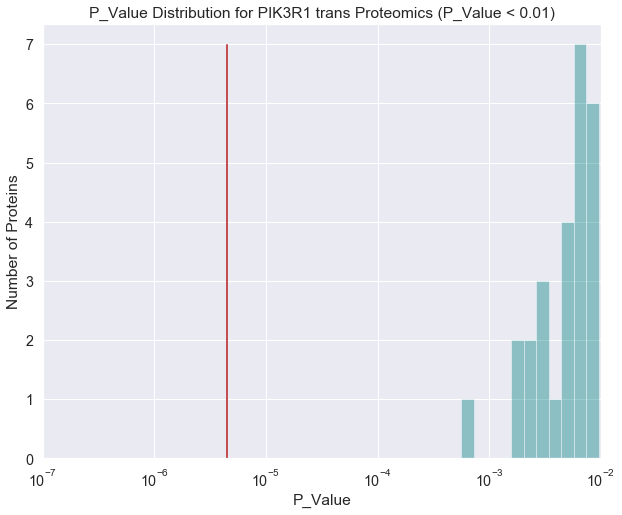

In [18]:
# Select p-values within range 0 - end_value 
prot_end_value = 0.01
prot_zoomed = prot_pval_series.loc[prot_pval_series <= prot_end_value]

# Format size of figure and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

# Create log scale for the x-axis
plt.xscale('log')
zoomed_log_min, zoomed_log_max = np.log10(prot_zoomed.min()),np.log10(prot_zoomed.max())
prot_bins_zoomed = np.logspace(zoomed_log_min - 1, zoomed_log_max, 20) # change this number for more or less bins
histogram = sns.distplot(prot_zoomed, bins = prot_bins_zoomed, kde=False, color='teal')

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Proteomics (P_Value < " + str(prot_end_value) + ")")
histogram.set(ylabel = 'Number of Proteins')
plt.xlim([10e-8,10e-3]) # change x-axis range
#plt.ylim([0.0,20]) # change y axis intervals

# Create bonferroni cutoff line 
plt.axvline(prot_bonferroni_cutoff, 0, .95, linewidth=2, color='r') # cutoff line parameters: (cutoff, 0, height)

plt.show()
plt.clf()
plt.close()

In [28]:
# Gene set enrichment analysis for 50 genes
prot_gsea = prot_all_comparisons.sort_values(by = 'P_Value')
prot_first_fifty = prot_gsea.iloc[:100]

# create gene list
prot_genes = prot_first_fifty['Comparison']
prot_genes.replace(to_replace = '_proteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
prot_genes_list = list(prot_genes)
print("Number of Proteomics comparisons for gsea: ", len(prot_genes_list))

prot_enr = gp.enrichr(gene_list = prot_genes_list, description='Proteomics_Comparisons', gene_sets='KEGG_2016', 
                       outdir='Enrichment Analysis')

prot_enr.res2d.head()

Number of Proteomics comparisons for gsea:  100


2019-11-02 16:23:09,743 Warning: No enrich terms using library KEGG_2016 when cutoff = 0.05


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
0,Sulfur relay system_Homo sapiens_hsa04122,2/10,0.001085,0.317916,0,0,40.000000,273.045595,TRMU;MOCS2,KEGG_2016
1,N-Glycan biosynthesis_Homo sapiens_hsa00510,2/49,0.024991,1.000000,0,0,8.163265,30.116179,ALG9;ALG11,KEGG_2016
2,Amyotrophic lateral sclerosis (ALS)_Homo sapie...,2/51,0.026921,1.000000,0,0,7.843137,28.351614,CASP9;CCS,KEGG_2016
3,RNA degradation_Homo sapiens_hsa03018,2/77,0.056857,1.000000,0,0,5.194805,14.894623,ZCCHC7;CNOT6L,KEGG_2016
4,Folate biosynthesis_Homo sapiens_hsa00790,1/14,0.067791,1.000000,0,0,14.285714,38.447526,MOCS2,KEGG_2016


# Phosphoproteomics: All Proteins

In [21]:
phos = 'phosphoproteomics'

try:
    print("\nGene: ", gene)

    # Create dataframe in order to do comparisons with wrap_ttest
    phosdf = brain.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=phos)
    phosdf = brain.reduce_multiindex(phosdf, flatten = True)
    phosdf = phosdf.loc[phosdf['Sample_Status'] == 'Tumor']
    
    #Remove Cis interactions
    phosdf = phosdf.loc[:,~phosdf.columns.str.contains(gene+'_phosphoproteomics')]
    phosdf = phosdf.dropna(axis=1, how='all') # drop columns with all NaN data
    
    
    # Create the binary valued column needed to do the comparison
    for ind, row in phosdf.iterrows():
        if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
            phosdf.at[ind,'Label'] = 'Mutated'
        else:
            phosdf.at[ind,'Label'] = 'Wildtype'

    # Format the datafram correctly'''
    phosdf = phosdf.drop(gene+"_Mutation",axis=1)
    phosdf = phosdf.drop(gene+"_Location",axis=1)
    phosdf = phosdf.drop(gene+"_Mutation_Status", axis=1)
    phosdf = phosdf.drop("Sample_Status",axis=1)

    # Make list of columns to be compared using t-tests
    phos_col_list = list(phosdf.columns)
    phos_col_list.remove('Label')
    
    print("Doing t-test comparisons\n")
    
    #Call wrap_ttest, pass in formatted dataframe
    phos_all_comparisons = al.wrap_ttest(phosdf, 'Label', phos_col_list, return_all=True)
    
    phos_num_comparisons = len(phos_col_list)
    print("Number of comparisons:", phos_num_comparisons)
    phos_bonferroni_cutoff = .05 / phos_num_comparisons
    print("Bonferroni cutoff = ", phos_bonferroni_cutoff)
    print("Logged Bonferroni cutoff = ", phos_bonferroni_cutoff)
            
        
except Exception as e:
    print("Error in Comparison")
    print(e)


Gene:  PIK3R1


Doing t-test comparisons

No significant comparisons.
Number of comparisons: 101254
Bonferroni cutoff =  4.938076520433761e-07
Logged Bonferroni cutoff =  4.938076520433761e-07


Print Significant Comparisons

In [22]:
phos_all_comparisons = phos_all_comparisons.dropna(axis=0)
phos_sig_comparisons = phos_all_comparisons.loc[phos_all_comparisons['P_Value'] <= phos_bonferroni_cutoff]
print("Number of significant Phosphoproteomics comparisons: ", len(phos_sig_comparisons))
phos_sig_comparisons.head()

Number of significant Phosphoproteomics comparisons:  0


,Comparison,P_Value


Phosphoproteomics Histograms

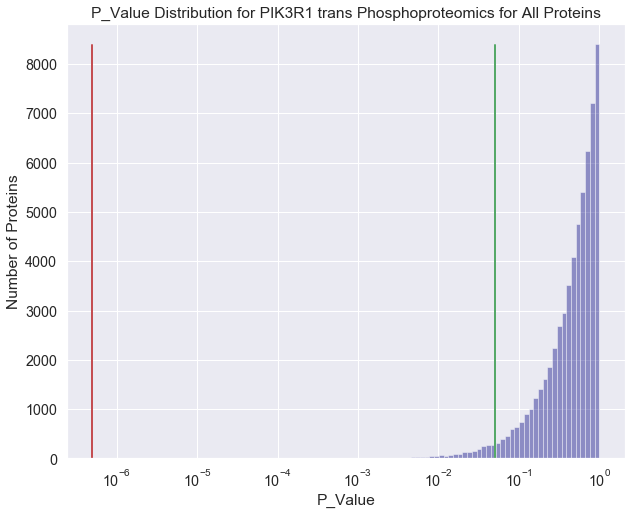

In [23]:
# Create series of p-values for Histogram
phos_pval_series = phos_all_comparisons['P_Value']

# Format figure size and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

# Create log scale for the x-axis
plt.xscale('log')
phos_log_min, phos_log_max = np.log10(phos_pval_series.min()), np.log10(phos_pval_series.max())
phos_bins = np.logspace(phos_log_min - 1, phos_log_max, 100) # change bin number here
histogram = sns.distplot(phos_pval_series, bins = phos_bins, kde=False, color='navy') 

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Phosphoproteomics for All Proteins")
histogram.set(ylabel = 'Number of Proteins')
#plt.xlim([10e-10,10e-1]) # change x-axis range
#plt.ylim([0, 3500]) # change y-axis range

# Graph cutoffs: alpha = green, bonferroni = red
plt.axvline(phos_bonferroni_cutoff, 0, 0.95, linewidth=2, color='r')
plt.axvline(0.05, 0, 0.95, linewidth=2, color='g')

plt.show()
plt.clf()
plt.close()

Phosphoproteomics zoomed in

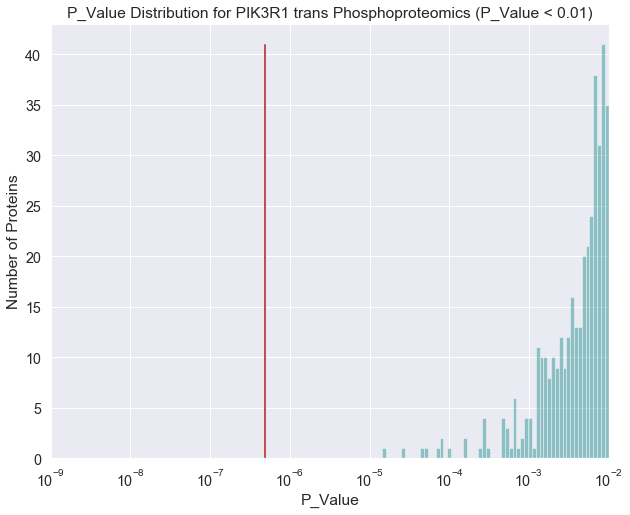

In [29]:
# Select p-values within range 0 - end_value 
phos_end_value = 0.01
phos_zoomed = phos_pval_series.loc[phos_pval_series <= phos_end_value]

# Format size of figure and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

# Create log scale for the x-axis
plt.xscale('log')
phos_zoomed_log_min, phos_zoomed_log_max = np.log10(phos_zoomed.min()),np.log10(phos_zoomed.max())
phos_bins_zoomed = np.logspace(phos_zoomed_log_min - 1, phos_zoomed_log_max, 80) # change this number for more or less bins
histogram = sns.distplot(phos_zoomed, bins = phos_bins_zoomed, kde=False, color='teal')

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Phosphoproteomics (P_Value < " + str(phos_end_value) + ")")
histogram.set(ylabel = 'Number of Proteins')
plt.xlim([10e-10,10e-3]) # change x-axis range
#plt.ylim([0.0,20]) # change y axis intervals

# Create bonferroni cutoff line 
plt.axvline(phos_bonferroni_cutoff, 0, .95, linewidth=2, color='r') # cutoff line parameters: (cutoff, 0, height)

plt.show()
plt.clf()
plt.close()

In [25]:
# Gene set enrichment analysis for 100 genes
phos_gsea = phos_all_comparisons.sort_values(by = 'P_Value')
phos_first_fifty = phos_gsea.iloc[:150]

# create gene list
phos_genes = phos_first_fifty['Comparison']
phos_genes.replace(to_replace = '_phosphoproteomics.*$', value = '', 
                        inplace = True, regex = True) # shorten column names
phos_genes_list = list(phos_genes)
print("Number of Phosphoproteomics comparisons for gsea: ", len(phos_genes_list))

phos_enr = gp.enrichr(gene_list = phos_genes_list, description='Phosphoproteomics_Comparisons', gene_sets='KEGG_2016', 
                       outdir='Enrichment Analysis')

phos_enr.res2d.head()

Number of Phosphoproteomics comparisons for gsea:  150


2019-11-02 16:21:17,780 Warning: No enrich terms using library KEGG_2016 when cutoff = 0.05


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
0,Bacterial invasion of epithelial cells_Homo sa...,4/78,0.002255,0.660678,0,0,7.274050,44.332872,ARHGAP10;ARPC1B;GAB1;CTNNB1,KEGG_2016
1,Rap1 signaling pathway_Homo sapiens_hsa04015,6/211,0.003871,0.567058,0,0,4.033478,22.403224,MAGI1;NGFR;DOCK4;CTNNB1;ADCY8;SIPA1L3,KEGG_2016
2,Lysine degradation_Homo sapiens_hsa00310,3/52,0.005890,0.575275,0,0,8.183306,42.016915,KMT2D;KMT2B;SETD1A,KEGG_2016
3,Tight junction_Homo sapiens_hsa04530,4/139,0.016956,1.000000,0,0,4.081841,16.642122,MAGI1;TJP1;CTNNB1;SHROOM1,KEGG_2016
4,Circadian rhythm_Homo sapiens_hsa04710,2/30,0.018868,1.000000,0,0,9.456265,37.543882,PRKAA1;CRY2,KEGG_2016
